In [2]:
!{sys.executable} -m pip install seaborn

     -------------------------------------- 285.1/285.1 kB 4.4 MB/s eta 0:00:00
     --------------------------------------- 10.4/10.4 MB 13.4 MB/s eta 0:00:00
     ------------------------------------- 500.8/500.8 kB 15.8 MB/s eta 0:00:00


In [10]:
import numpy as np    
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt
 
ZERO = 1e-7
 
def plot_x(x, t, alpha=[], C=0):
    #sns.scatterplot(data=dat[:,0], x=dat[:, 1], style=labels,
    #hue=labels, markers=['s', 'P'],
    #palette=['magenta', 'green'])
    plt.scatter(dat[:,0],dat[:,1])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > ZERO)[0]
        for i in ind_sv:   
            plt.gca().text(dat[i,0], dat[i, 1]-.25, alpha_str[i] )
 
# Objective function
def lagrange_dual(alpha, x, t):
    result = 0
    ind_sv = np.where(alpha > ZERO)[0]
    for i in ind_sv:
        for k in ind_sv:
            result = result + alpha[i]*alpha[k]*t[i]*t[k]*np.dot(x[i, :], x[k, :]) 
    result = 0.5*result - sum(alpha)     
    return result 
 
def optimize_alpha(x, t, C):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(t, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x, t), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha
 
def get_w(alpha, t, x):
    m = len(x)
    # Get all support vectors
    w = np.zeros(x.shape[1])
    for i in range(m):
        w = w + alpha[i]*t[i]*x[i, :]        
    return w
 
def get_w0(alpha, t, x, w, C):
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > ZERO)&(alpha < C_numeric))[0]
    w0 = 0.0
    for s in ind_sv:
        w0 = w0 + t[s] - np.dot(x[s, :], w)
    # Take the average    
    w0 = w0 / len(ind_sv)
    return w0
 
def classify_points(x_test, w, w0):
    # get y(x_test)
    predicted_labels = np.sum(x_test*w, axis=1) + w0
    predicted_labels = np.sign(predicted_labels)
    # Assign a label arbitrarily a +1 if it is zero
    predicted_labels[predicted_labels==0] = 1
    return predicted_labels
 
def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total*100
 
def plot_hyperplane(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    y_coord = -w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, y_coord, color='red')
 
def plot_margin(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    ypos_coord = 1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, ypos_coord, '--', color='green') 
    yneg_coord = -1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, yneg_coord, '--', color='magenta')  
 
def display_SVM_result(x, t, C):
    # Get the alphas
    alpha = optimize_alpha(x, t, C)   
    # Get the weights
    w = get_w(alpha, t, x)
    w0 = get_w0(alpha, t, x, w, C)
    plot_x(x, t, alpha, C)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plot_hyperplane(w, w0)
    plot_margin(w, w0)
    plt.xlim(xlim)
    plt.ylim(ylim)
    # Get the misclassification error and display it as title
    predictions = classify_points(x, w, w0)
    err = misclassification_rate(t, predictions)
    title = 'C = ' + str(C) + ',  Errors: ' + '{:.1f}'.format(err) + '%'
    title = title + ',  total SV = ' + str(len(alpha[alpha > ZERO]))
    plt.title(title)
    


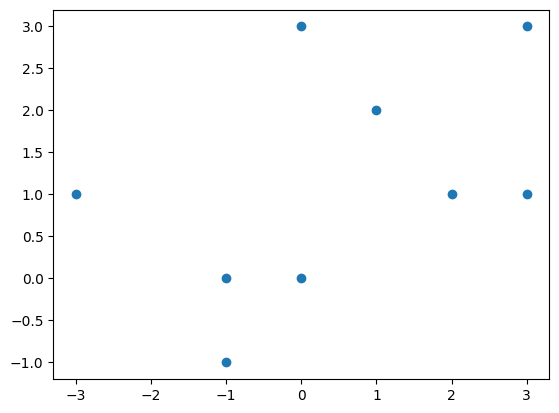

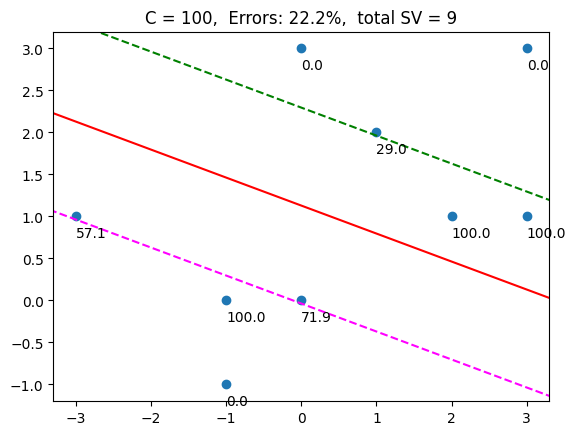

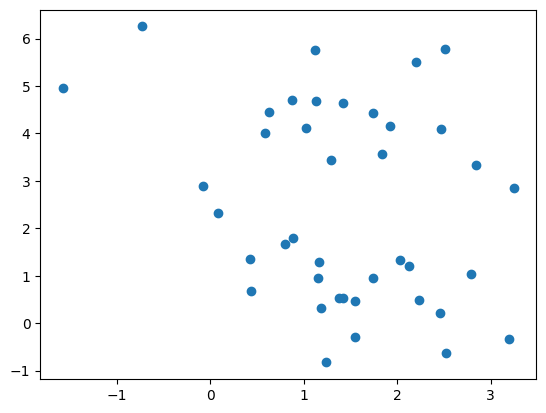

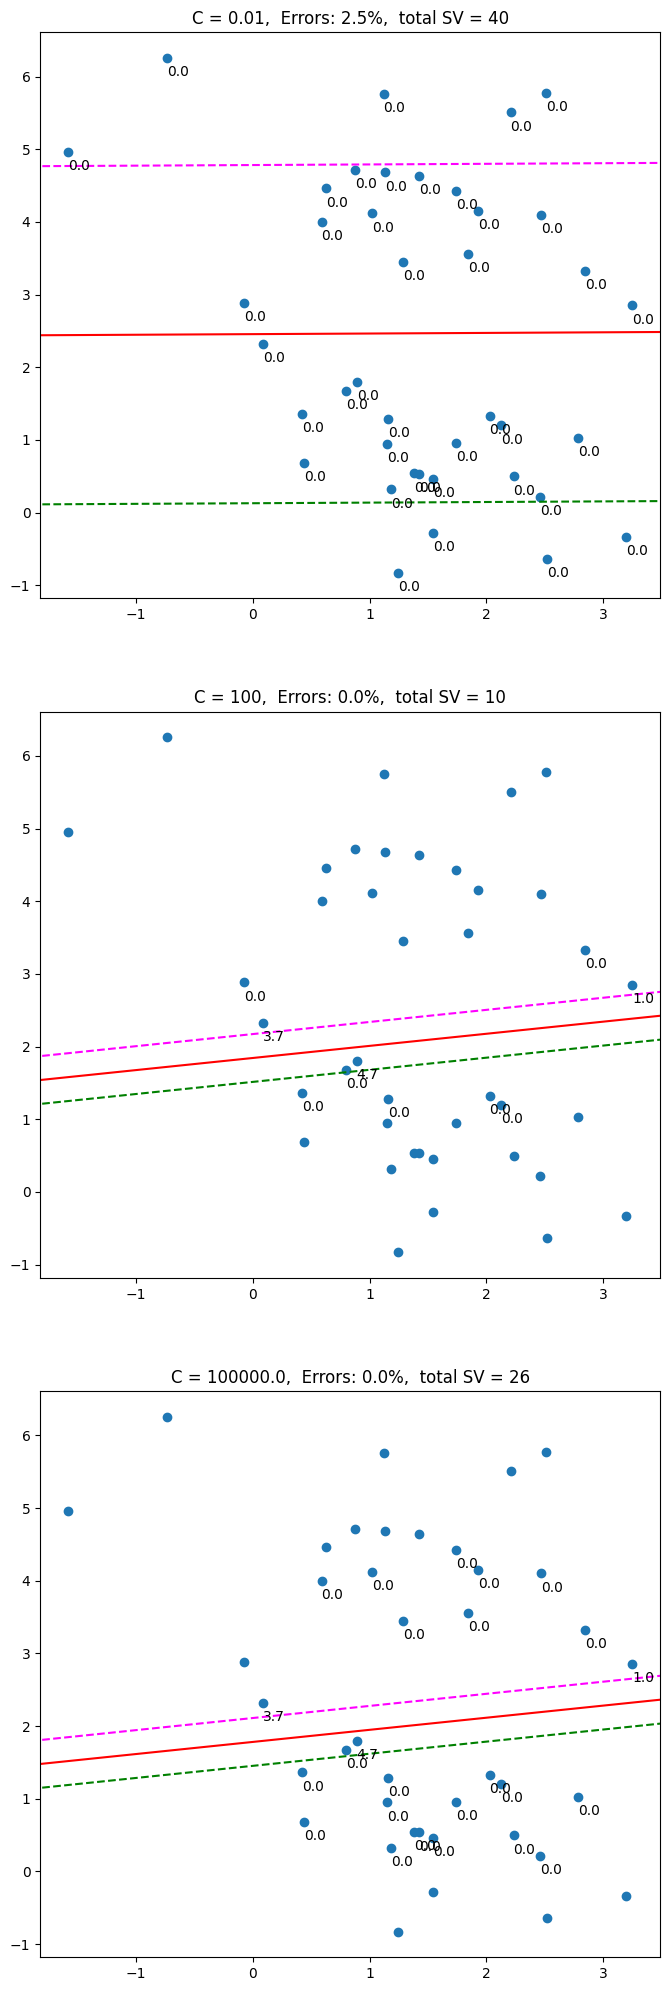

In [11]:
dat = np.array([[0, 3], [-1, 0], [1, 2], [2, 1], [3,3], [0, 0], [-1, -1], [-3, 1], [3, 1]])
labels = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1])                  
plot_x(dat, labels)
plt.show()
display_SVM_result(dat, labels, 100)    
plt.show()
 
dat, labels = dt.make_blobs(n_samples=[20,20],
                           cluster_std=1,
                           random_state=0)
labels[labels==0] = -1
plot_x(dat, labels)
 
fig = plt.figure(figsize=(8,25))
 
i=0
C_array = [1e-2, 100, 1e5]
 
for C in C_array:
    fig.add_subplot(311+i)    
    display_SVM_result(dat, labels, C)  
    i = i + 1